**Aufgabe 6.**

Sei $y: [0, T] \to \mathbb{R}^n$ Lösung des Anfangswertproblems $y^\prime = f(y)$ mit $y(0) = y_0$.
Programmieren Sie einen allgemeinen Löser für solche Probleme.
Eingabedaten sollten die Funktion $f$, eine Diskretisierung des Intervalls $[0, T]$, der Startwert $y_0$ und das Butcher-Schema eines beliebigen, expliziten Runge-Kutta-Verfahrens sein. Ausgabedaten wären die Approximationen $y_i$ an $y(t_i)$ aus dem zugehörigen Runge-Kutta-Verfahren.
Verwenden Sie Ihr Programm, um folgendes Räuber-Beute-Modell numerisch zu lösen.

Modell:
Sei $y_\mathrm{J}(t)$ zu jedem Zeitpunkt $t$ die Größe einer Jäger-Population und $y_\mathrm{B}(t)$ die Größe einer Beutepopulation.
Die Wachstumsrate der Populationen ergibt sich aus der Differenz der Geburtenrate und der Sterberate.
Dabei nehmen wir an, dass für die Beutepopulation genügend Nahrung vorhanden sei, sodass die Geburtenrate $\alpha > 0$ konstant ist.
Bei jedem Zusammentreffen zwischen Jäger und Beute wird mit einer ebenfalls konstanten Rate $\beta > 0$ die Beute gefressen.
Die natürliche Sterberate der Beute sei im Vergleich dazu vernachlässigbar.
Dann ergibt sich für die Beute-Population die Differentialgleichung

\begin{align}
  \label{Beute-Population}
  y_\mathrm{B}^\prime(t)
  =
  \alpha y_\mathrm{B}(t) - \gamma y_\mathrm{J}(t) y_\mathrm{B}(t).
  \tag{1a}
\end{align}

Für die Jäger-Population nehmen wir an, dass diese proportional mit Faktor $\gamma > 0$ zur Anzahl der Begegnungen mit der Beute wächst.
Die natürliche Sterberate der Jäger $\delta > 0$ ist hier nicht vernachlässigbar.
Insgesamt ergibt sich damit für die Jäger-Population

\begin{align}
  \label{Jäger-Population}
  y_\mathrm{J}^\prime(t)
  =
  \gamma y_\mathrm{J}(t) y_\mathrm{B}(t) - \delta y_\mathrm{J}(t).
  \tag{1b}
\end{align}

Zum Testen können Sie z.B. die Modellparameter $\alpha = 2$, $\beta = \gamma = 0.01$, $\delta = 1$, $y_\mathrm{J}(0) = 150$ und $y_\mathrm{B}(0) = 300$ verwenden.
Zur Diskretisierung könnten Sie mit einer äquidistanten Zerlegung von $t \in [0, 100]$ mit $h = 0.01$ und dem den expliziten Runge-Kutta-Verfahren aus der Vorlesung (Example 2.23 und Example 2.25) starten.
Variieren Sie aber Modellparameter und Diskretisierung
und studieren Sie die Effekte auf die numerischen Ergebnisse.

In [3]:
# ---------------------------------------------------------------- #

import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------------- #

In [4]:
# ---------------------------------------------------------------- #

# The following functions are meant to check, whether the provided data is flawed:
# mesh .............. sorted
# butcher tableau ...
# ... sorted c within 0 and 1 and
# ... strict lower triangular A
# ... dimensions fit

# ---------------------------------------------------------------- #

def is_sorted(Delta):
    Delta_sorted = np.sort(Delta)
    return bool(np.prod(Delta == Delta_sorted))

def is_butcher_tableau(butcher_tableau):

    c, A, b = butcher_tableau

    n, m = np.shape(A)
    is_square_matrix = (n == m)
    A_strict_lower_triangular = np.tril(A, -1)
    is_strict_lower_triangular = bool(np.prod(A == A_strict_lower_triangular))
    A_is_ok = is_square_matrix and is_strict_lower_triangular

    is_between_0_and_1 = bool(np.prod(0 <= c)) and bool(np.prod(c <= 1))
    c_is_ok = is_between_0_and_1 and is_sorted(c)

    have_same_dimensions = (np.shape(c)[0] == np.shape(A)[0]) and (np.shape(A)[0] == np.shape(b)[0])

    return (A_is_ok and c_is_ok and have_same_dimensions)

# ---------------------------------------------------------------- #

def test():

    A = np.array([[0, 0, 0],
                  [1, 0, 0],
                  [2, 3, 0]])

    c = np.linspace(0, 1, 3)
    b = np.random.rand(3)

    print("c =")
    print(c)
    print("")

    print("A =")
    print(A)
    print("")

    print("b =")
    print(b)
    print("")

    butcher_tableau = (c, A, b)

    print("is_butcher_tableau is", is_butcher_tableau(butcher_tableau), "for butcher_tableau")
    print("")

    T = 5
    n = 5
    Delta = np.linspace(0, T, n)

    print("Delta =")
    print(Delta)
    print("")

    print("is_sorted is", is_sorted(Delta), "for Delta")

# test()

# ---------------------------------------------------------------- #

In [5]:
# ---------------------------------------------------------------- #

# The following functions are meant to return a more abstract dot product:

# x ... scalar
# y ... vector

def dot(x, y):

    assert len(x) == len(y)

    n = len(x)
    dot_product = 0

    for i in range(n):
        dot_product += x[i]*y[i]

    return dot_product

# ---------------------------------------------------------------- #

def test(n):

    x = np.array(range(n))
    y = [np.array([0, 1])]*n

#     print(x)
#     print(y)
    print(dot(x, y))

# test(4)

# ---------------------------------------------------------------- #

In [6]:
# ---------------------------------------------------------------- #

def runge_kutta_method(f, Delta, y_0, butcher_tableau):

    # check if input data is legal
    assert is_sorted(Delta) and Delta[0] == 0
    assert is_butcher_tableau(butcher_tableau)

    c, A, b = butcher_tableau
    m = np.shape(c)[0]

    # inkrementelle Funktion
    def Phi(t, y, h):

        # Rekursions-Anfang
        k = [None]*m
        k[0] = f(t + c[0]*h, y)

        # Rekursions-Schritt
        for i in range(1, m):

            first  = t + c[i]*h
            second = y + h*dot(A[i][:i-1:], k[:i-1:])

            k[i] = f(first, second)

        return np.array(dot(b, k))

    N = np.shape(Delta)[0] - 1
    t = Delta
    h = t[1::] - t[:-1:]

    # Rekursions-Anfang
    y_approx = [None]*(N+1)
    y_approx[0] = y_0

    # Rekursions-Schritt
    for ell in range(N):
        y_approx[ell+1] = y_approx[ell] + h[ell]*Phi(t[ell], y_approx[ell], h[ell])

    # return approximation
    return np.array(y_approx)

# ---------------------------------------------------------------- #

In [7]:
# ---------------------------------------------------------------- #

# Approximation aus Aufgabe 1:

def test(p):

    N_array = [2**n for n in range(p)]

    def f(t, y):
        return t*y

    T = 1
    y_0 = 1

    # Example 2.23: The explicit Euler method
    c = np.array([0])
    A = np.array([[0]])
    b = np.array([1])
    butcher_tableau = (c, A, b)

    for N in N_array:

        Delta = np.linspace(0, T, N+1)
        y_approx = runge_kutta_method(f, Delta, y_0, butcher_tableau)

        plt.plot(Delta, y_approx)

    Delta = np.linspace(0, T, int(T/0.1) + 1)
    y = np.exp(Delta**2 / 2)
    plt.plot(Delta, y)

    plt.grid(linestyle = ':')
    plt.show()

# test(4)

# ---------------------------------------------------------------- #

GETTING AN OVERVIEW ...

----------------------------------------------------------------
Räuber-Beute-Modell wird mit folgenden Parametern ausgeführt ...

Modellparameter:
alpha = 2
beta  = 0.01
gamma = 0.01
delta = 1
y_J_0 = 150
y_B_0 = 300

Diskretisierung:
T = 100
h = 0.01

Runge-Kutta-Verfahren:
c =
[0.  0.5 0.5 1. ]
A =
[[0.  0.  0.  0. ]
 [0.5 0.  0.  0. ]
 [0.  0.5 0.  0. ]
 [0.  0.  1.  0. ]]
b =
[0.16666667 0.33333333 0.33333333 0.16666667]


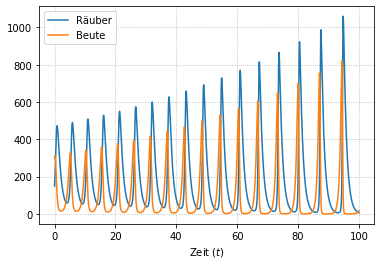

----------------------------------------------------------------

TESTING FOR FIDELITY ...

Wir verschlechtern die Auflösung der Diskretisierung ...

----------------------------------------------------------------
Räuber-Beute-Modell wird mit folgenden Parametern ausgeführt ...

Modellparameter:
alpha = 2
beta  = 0.01
gamma = 0.01
delta = 1
y_J_0 = 150
y_B_0 = 300

Diskretisierung:
T = 100
h = 0.02

Runge-Kutta-Verfahren:
c =
[0.  0.5 0.5 1. ]
A =
[[0.  0.  0.  0. ]
 [0.5 0.  0.  0. ]
 [0.  0.5 0.  0. ]
 [0.  0.  1.  0. ]]
b =
[0.16666667 0.33333333 0.33333333 0.16666667]


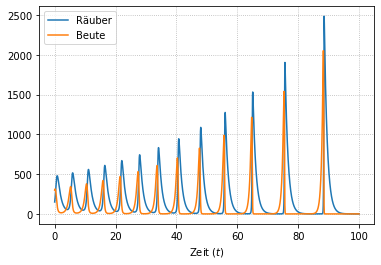

----------------------------------------------------------------

Wir verschlechtern die Auflösung der Diskretisierung ...

----------------------------------------------------------------
Räuber-Beute-Modell wird mit folgenden Parametern ausgeführt ...

Modellparameter:
alpha = 2
beta  = 0.01
gamma = 0.01
delta = 1
y_J_0 = 150
y_B_0 = 300

Diskretisierung:
T = 100
h = 0.03

Runge-Kutta-Verfahren:
c =
[0.  0.5 0.5 1. ]
A =
[[0.  0.  0.  0. ]
 [0.5 0.  0.  0. ]
 [0.  0.5 0.  0. ]
 [0.  0.  1.  0. ]]
b =
[0.16666667 0.33333333 0.33333333 0.16666667]


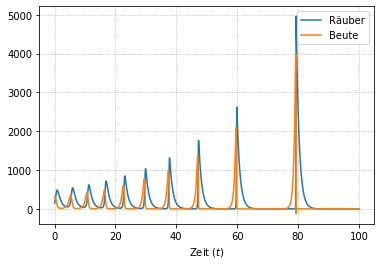

----------------------------------------------------------------

Wir verschlechtern die Auflösung der Diskretisierung ...

----------------------------------------------------------------
Räuber-Beute-Modell wird mit folgenden Parametern ausgeführt ...

Modellparameter:
alpha = 2
beta  = 0.01
gamma = 0.01
delta = 1
y_J_0 = 150
y_B_0 = 300

Diskretisierung:
T = 100
h = 0.04

Runge-Kutta-Verfahren:
c =
[0.  0.5 0.5 1. ]
A =
[[0.  0.  0.  0. ]
 [0.5 0.  0.  0. ]
 [0.  0.5 0.  0. ]
 [0.  0.  1.  0. ]]
b =
[0.16666667 0.33333333 0.33333333 0.16666667]


C:\Users\richa\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: overflow encountered in double_scalars
C:\Users\richa\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: overflow encountered in double_scalars
C:\Users\richa\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()


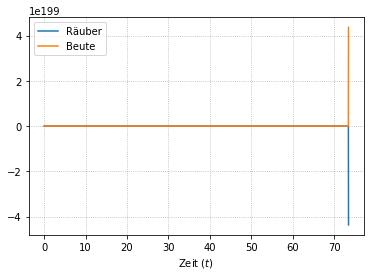

----------------------------------------------------------------

... Ergebnis:
Peaks werden größer und weniger!

HAVE FUN ...

Wir testen nun folgendes Szenario ...
# Beute wächst normal
# Beute stirbt normal
# Räuber wachsen schnell
# Räuber sterben langsam (no pun intended)

----------------------------------------------------------------
Räuber-Beute-Modell wird mit folgenden Parametern ausgeführt ...

Modellparameter:
alpha = 2
beta  = 0.01
gamma = 0.1
delta = 0.1
y_J_0 = 300
y_B_0 = 300

Diskretisierung:
T = 50
h = 0.01

Runge-Kutta-Verfahren:
c =
[0.  0.5 0.5 1. ]
A =
[[0.  0.  0.  0. ]
 [0.5 0.  0.  0. ]
 [0.  0.5 0.  0. ]
 [0.  0.  1.  0. ]]
b =
[0.16666667 0.33333333 0.33333333 0.16666667]


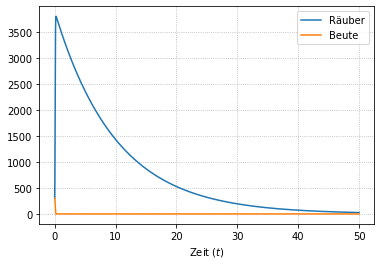

----------------------------------------------------------------

... Ergebnis:
Apokalypse! Alle sterben!

Wir testen nun folgendes Szenario ...
# Beute wächst schnell
# Beute stirbt langsam
# Räuber wachsen normal
# Räuber sterben normal

# Beute anfangs mehr

----------------------------------------------------------------
Räuber-Beute-Modell wird mit folgenden Parametern ausgeführt ...

Modellparameter:
alpha = 4
beta  = 0.005
gamma = 0.01
delta = 1
y_J_0 = 150
y_B_0 = 600

Diskretisierung:
T = 50
h = 0.01

Runge-Kutta-Verfahren:
c =
[0.  0.5 0.5 1. ]
A =
[[0.  0.  0.  0. ]
 [0.5 0.  0.  0. ]
 [0.  0.5 0.  0. ]
 [0.  0.  1.  0. ]]
b =
[0.16666667 0.33333333 0.33333333 0.16666667]


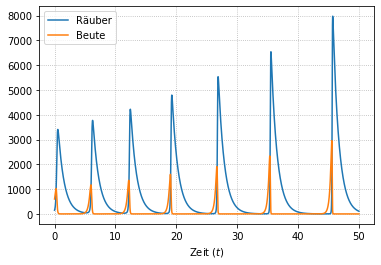

----------------------------------------------------------------

... Ergebnis:
System SEHR gesund!

Wir testen nun folgendes Szenario ...
# Beute wächst normal
# Beute stirbt normal
# Räuber wachsen normal
# Räuber sterben schnell

----------------------------------------------------------------
Räuber-Beute-Modell wird mit folgenden Parametern ausgeführt ...

Modellparameter:
alpha = 2
beta  = 0.01
gamma = 0.01
delta = 2
y_J_0 = 150
y_B_0 = 300

Diskretisierung:
T = 50
h = 0.01

Runge-Kutta-Verfahren:
c =
[0.  0.5 0.5 1. ]
A =
[[0.  0.  0.  0. ]
 [0.5 0.  0.  0. ]
 [0.  0.5 0.  0. ]
 [0.  0.  1.  0. ]]
b =
[0.16666667 0.33333333 0.33333333 0.16666667]


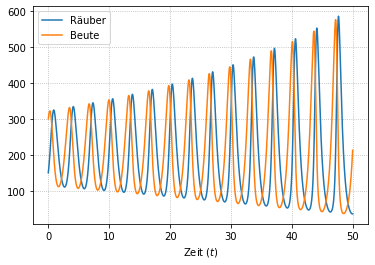

----------------------------------------------------------------

... Ergebnis:
Polulationen sind und bleiben gleich!

Wir testen nun folgendes Szenario ...
# Beute wächst normal
# Beute stirbt langsam
# Räuber wachsen normal
# Räuber sterben schnell

----------------------------------------------------------------
Räuber-Beute-Modell wird mit folgenden Parametern ausgeführt ...

Modellparameter:
alpha = 2
beta  = 0.005
gamma = 0.01
delta = 2
y_J_0 = 150
y_B_0 = 300

Diskretisierung:
T = 50
h = 0.01

Runge-Kutta-Verfahren:
c =
[0.  0.5 0.5 1. ]
A =
[[0.  0.  0.  0. ]
 [0.5 0.  0.  0. ]
 [0.  0.5 0.  0. ]
 [0.  0.  1.  0. ]]
b =
[0.16666667 0.33333333 0.33333333 0.16666667]


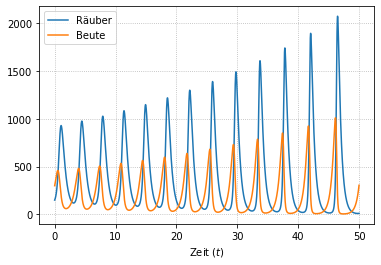

----------------------------------------------------------------

... Ergebnis:
Räuber profitieren von dem Wohle der Beute!

Wir testen nun folgendes Szenario ...
# Beute wächst normal
# Beute stirbt langsam
# Räuber wachsen schnell
# Räuber sterben schnell

----------------------------------------------------------------
Räuber-Beute-Modell wird mit folgenden Parametern ausgeführt ...

Modellparameter:
alpha = 2
beta  = 0.005
gamma = 0.02
delta = 2
y_J_0 = 150
y_B_0 = 300

Diskretisierung:
T = 50
h = 0.01

Runge-Kutta-Verfahren:
c =
[0.  0.5 0.5 1. ]
A =
[[0.  0.  0.  0. ]
 [0.5 0.  0.  0. ]
 [0.  0.5 0.  0. ]
 [0.  0.  1.  0. ]]
b =
[0.16666667 0.33333333 0.33333333 0.16666667]


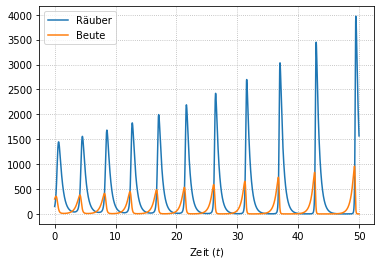

----------------------------------------------------------------

... Ergebnis:
Räuber profitieren von dem Wohle der Beute NOCH MEHR UND SCHNELLER!
Beute wird etwas weniger!



In [43]:
# ---------------------------------------------------------------- #

# Räuber-Beute-Modell:

def test(alpha, beta, gamma, delta, y_J_0, y_B_0, T, h, butcher_tableau):

    assert alpha > 0
    assert beta  > 0
    assert gamma > 0
    assert delta > 0

    Delta   = np.arange(0, T, h)
    y_0     = np.array([y_J_0, y_B_0])
    c, A, b = butcher_tableau

    separator = "-"*64

    print(separator)

    print("Räuber-Beute-Modell wird mit folgenden Parametern ausgeführt ...")
    print("")

    print("Modellparameter:")
    print("alpha =", alpha)
    print("beta  =", beta)
    print("gamma =", gamma)
    print("delta =", delta)
    print("y_J_0 =", y_J_0)
    print("y_B_0 =", y_B_0)
    print("")

    print("Diskretisierung:")
    print("T =", T)
    print("h =", h)
    print("")

    print("Runge-Kutta-Verfahren:")
    print("c =")
    print(c)
    print("A =")
    print(A)
    print("b =")
    print(b)

    def f(t, y):

        predators = gamma*y[0]*y[1] - delta*y[0]
        prey      = alpha*y[1] - beta*y[0]*y[1]

        return np.array([predators, prey])

    y_approx = runge_kutta_method(f, Delta, y_0, butcher_tableau)

    predators, prey = y_approx.transpose()

    plt.plot(Delta, predators, label = "Räuber")
    plt.plot(Delta, prey,      label = "Beute")
    plt.legend()
    plt.xlabel("Zeit ($t$)")
    plt.grid(linestyle = ':')
    plt.show()

    print(separator)
    print("")

# ---------------------------------------------------------------- #

# Wir starten mit den Parametern aus der Angabe.
# Anschließend, variieren wir Modellparameter und Diskretisierung
# und studieren die Effekte auf die numerischen Ergebnisse.

# Example 2.25: Classical Runge-Kutta method RK4
c = np.array([0, 1/2, 1/2, 1])
A = np.array([[0,   0,   0, 0],
              [1/2, 0,   0, 0],
              [0,   1/2, 0, 0],
              [0,   0,   1, 0]])
b = np.array([1/6, 1/3, 1/3, 1/6])
butcher_tableau = (c, A, b)

# -------------------------------- #

# Goal:
# Getting an overview ...

print("GETTING AN OVERVIEW ...")
print("")

# Modellparameter
alpha = 2
beta  = 0.01
gamma = beta
delta = 1
y_J_0 = 150
y_B_0 = 300

# Diskretisierung
T = 100
h = 0.01

# show time
test(alpha, beta, gamma, delta, y_J_0, y_B_0, T, h, butcher_tableau)

# -------------------------------- #

# Goal:
# Testing for fidelity ...

print("TESTING FOR FIDELITY ...")
print("")

while h <= 0.03:

    print("Wir verschlechtern die Auflösung der Diskretisierung ...")
    h += 0.01
    print("")

    # show time
    test(alpha, beta, gamma, delta, y_J_0, y_B_0, T, h, butcher_tableau)

print("... Ergebnis:")
print("Peaks werden größer und weniger!")
print("")

# -------------------------------- #

# Goal:
# Have fun ...

print("HAVE FUN ...")
print("")

# zoom in
T = 50
# bump up resulution
h = 0.01

# ---------------- #

print("Wir testen nun folgendes Szenario ...")
print("# Beute wächst normal")
alpha = 2
print("# Beute stirbt normal")
beta  = 0.01
print("# Räuber wachsen schnell")
gamma = 0.01 * 10
print("# Räuber sterben langsam (no pun intended)")
delta = 1 / 10
print("")

# Räuber anfangs mehr
y_J_0 = 150 * 2
y_B_0 = 300

# show time
test(alpha, beta, gamma, delta, y_J_0, y_B_0, T, h, butcher_tableau)

print("... Ergebnis:")
print("Apokalypse! Alle sterben!")
print("")

# ---------------- #

print("Wir testen nun folgendes Szenario ...")
print("# Beute wächst schnell")
alpha = 2 * 2
print("# Beute stirbt langsam")
beta  = 0.01 / 2
print("# Räuber wachsen normal")
gamma = 0.01
print("# Räuber sterben normal")
delta = 1
print("")

print("# Beute anfangs mehr")
y_J_0 = 150
y_B_0 = 300 * 2
print("")

# show time
test(alpha, beta, gamma, delta, y_J_0, y_B_0, T, h, butcher_tableau)

print("... Ergebnis:")
print("System SEHR gesund!")
print("")

# ---------------- #

print("Wir testen nun folgendes Szenario ...")
print("# Beute wächst normal")
alpha = 2
print("# Beute stirbt normal")
beta  = 0.01
print("# Räuber wachsen normal")
gamma = 0.01
print("# Räuber sterben schnell")
delta = 1 * 2
print("")

# normal
y_J_0 = 150
y_B_0 = 300

# show time
test(alpha, beta, gamma, delta, y_J_0, y_B_0, T, h, butcher_tableau)

print("... Ergebnis:")
print("Populationen sind und bleiben gleich!")
print("")

# ---------------- #

print("Wir testen nun folgendes Szenario ...")
print("# Beute wächst normal")
alpha = 2
print("# Beute stirbt langsam")
beta  = 0.01 / 2
print("# Räuber wachsen normal")
gamma = 0.01
print("# Räuber sterben schnell")
delta = 1 * 2
print("")

# normal
y_J_0 = 150
y_B_0 = 300

# show time
test(alpha, beta, gamma, delta, y_J_0, y_B_0, T, h, butcher_tableau)

print("... Ergebnis:")
print("Räuber profitieren von dem Wohle der Beute!")
print("")

# ---------------- #

print("Wir testen nun folgendes Szenario ...")
print("# Beute wächst normal")
alpha = 2
print("# Beute stirbt langsam")
beta  = 0.01 / 2
print("# Räuber wachsen schnell")
gamma = 0.01 * 2
print("# Räuber sterben schnell")
delta = 1 * 2
print("")

# normal
y_J_0 = 150
y_B_0 = 300

# show time
test(alpha, beta, gamma, delta, y_J_0, y_B_0, T, h, butcher_tableau)

print("... Ergebnis:")
print("Räuber profitieren von dem Wohle der Beute NOCH MEHR UND SCHNELLER!")
print("Beute wird etwas weniger!")
print("")

# ---------------- #

# -------------------------------- #

# ---------------------------------------------------------------- #
